# P6 Classifiez automatiquement des biens de consommation : Traitement d'images

## Importation des librairies et des données

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sn; sn.set(font_scale=1.4)
import os     
import cv2  

import tensorflow as tf  
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn import decomposition
from sklearn.metrics import accuracy_score

In [2]:
class_names = ['Home furnishing','Beauty and Personal Care','Kichen and Dining','Home Decoration','Baby Care',
               'Watches','Computers']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [3]:
data = pd.read_csv('images_categories.csv')

data.head()

,Unnamed: 0,image_name,cat,label
0,0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnish,0
1,1,7b72c92c2f6c40268628ec5f14c6d590.jpg,babi care,4
2,2,64d5d4a258243731dc7bbb1eef49ad74.jpg,babi care,4
3,3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnish,0
4,4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnish,0


Nous importons désormais nos images.

In [4]:
folder = 'Images'
images = []
labels = []
output = []

os.listdir(folder)
for file in data.image_name:

    img_path = os.path.join(folder, file)

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE) 

    images.append(image)
    labels.append(data.loc[data.image_name==file,'label'].values)

images = np.array(images, dtype = 'float32')
labels = np.array(labels, dtype = 'int32')  

In [5]:
images = images/255.0

## Visualisation des paires (images / labels)
Nous pouvons visualiser une image aléatoire dans notre jeu de données.

In [6]:
def display_random_image(class_names, images, labels):
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[int(labels[index])])
    plt.show()

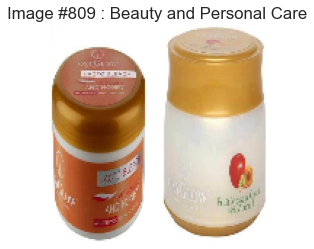

In [7]:
display_random_image(class_names, images, labels)

Nous pouvons également sortir 25 images aléatoire de notre jeu d'entrainement :

In [8]:
def display_examples(class_names, images, labels):

    fig = plt.figure(figsize=(15,15))
    fig.suptitle("Quelques images parmis notre jeu de données", fontsize=16)
    for i in range(25):
        index = np.random.randint(images.shape[0]-25)
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[index], cmap=plt.cm.binary)
        plt.xlabel(class_names[int(labels[index])])
    plt.show()

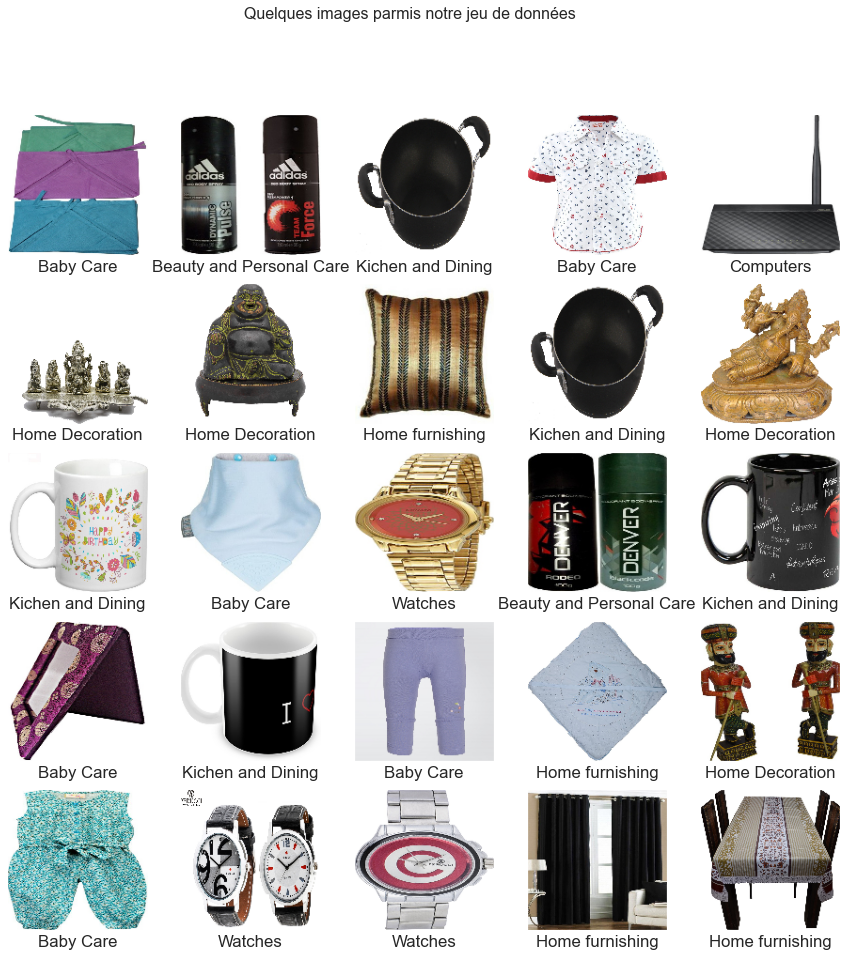

In [9]:
display_examples(class_names, images, labels)

## Approche Descripteurs

Nous allons créer notre dico de descripteurs que nous allons ensuite clusteriser.

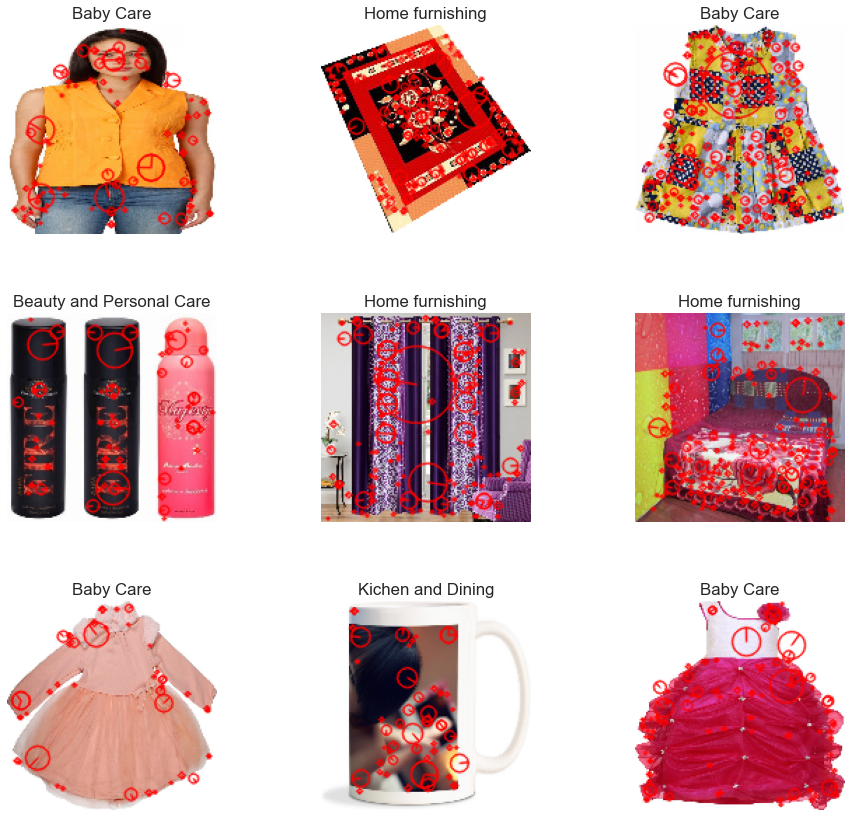

In [10]:
import random

L = 3
W = 3
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel()

for i in range(0, L * W):  
    index = np.random.randint(images.shape[0]-9)
    image8bit = cv2.normalize(images[index], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(image8bit,None)

    img = cv2.drawKeypoints(image=image8bit, outImage=images[index], keypoints = kp, flags = 4, color = (255, 0, 0))
    axes[i].set_title(class_names[int(labels[index])])
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [11]:
img.shape

(150, 150, 3)

Afin de créer notre vecteur avec nos SIFT features nous allons devoir remplir une array de shape (len(images), 150, 150, 3).

In [12]:
def create_SIFT_features(images):
    Feature_data = np.zeros((len(images),150,150,3))

    for i in range(len(images)):
        img = images[i]
        image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(image8bit,None)

        img = cv2.drawKeypoints(image=image8bit, outImage=img, keypoints = kp, flags = 4, color = (255, 0, 0))
        Feature_data[i] = img/255

        
    return Feature_data 

In [13]:
images_SIFT = create_SIFT_features(images) 
images_SIFT.shape

(1050, 150, 150, 3)

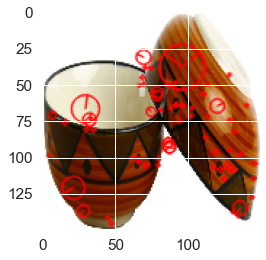

In [14]:
plt.imshow(images_SIFT[70], cmap='gray')

### Créations des descripteurs de chaque image
* Pour chaque image passage en gris et normalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [15]:
import time
sift_keypoints = []
temps1=time.time()
sift = cv2.SIFT_create()

for i in range(len(images)):
    if i%100 == 0 : print(i)
    img = images[i]
    image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    kp, des = sift.detectAndCompute(image8bit,None)
    if len(kp) > 0 :
        sift_keypoints.append(des)
    
sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all= np.concatenate(sift_keypoints_by_img)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (132761, 128)
temps de traitement SIFT descriptor :             5.93 secondes


C:\Users\maxim\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables.

Nous prenons pour nombre de clusters la racine carrée du nombre de descripteurs obtenus. 

In [16]:
from sklearn import cluster, metrics

temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  364
Création de 364 clusters de descripteurs ...
temps de traitement kmeans :            13.79 secondes


### Création des features des images
Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image
   
Soit les features d'une image correspondent à son histogramme d'une image, qui lui-même correspond au omptage pour une image du nombre de descripteurs par cluster.

In [17]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             1.53 secondes


### Réductions dimensionnelles
#### PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [18]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1049, 364)
Dimensions dataset après réduction PCA :  (1049, 318)


Nous sommes passés de 364 clusters à 317, c'est un début mais pas encore suffisant pour classer nos images. Nous testons maintenant une autre réduction dimensionnelle.
#### T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [19]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])

print(df_tsne.shape)

(1049, 2)


In [20]:
x = data["label"].drop(835, axis=0)

df_tsne["class"] = x
for i in range(len(df_tsne["class"])):
    df_tsne["class"][i] = class_names[x.iloc[i]]

df_tsne.head()

<ipython-input-20-17f0b3341a7b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tsne["class"][i] = class_names[x.iloc[i]]
C:\Users\maxim\Anaconda\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,tsne1,tsne2,class
0,3.200774,1.344020,Home furnishing
1,16.140194,-4.855813,Baby Care
2,8.484390,8.270129,Baby Care
3,0.344430,3.221649,Home furnishing
4,-2.194275,-11.653900,Home furnishing


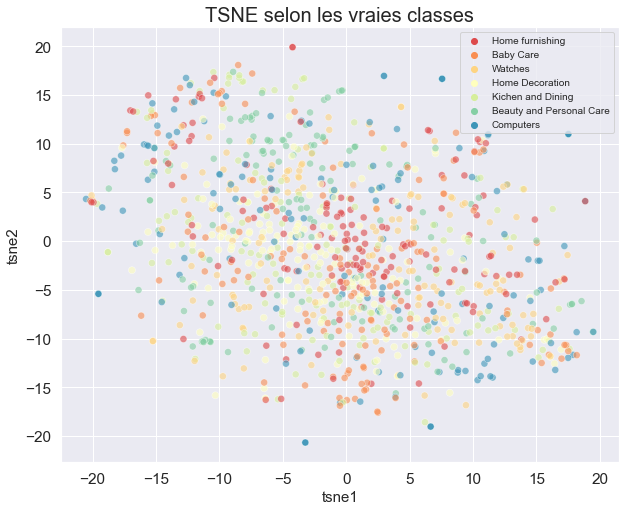

In [21]:
plt.figure(figsize=(10,8))

sn.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette="Spectral", s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 20)
plt.xlabel('tsne1', fontsize = 15)
plt.ylabel('tsne2', fontsize = 15)
plt.legend(prop={'size': 10}) 

plt.show()

Il est difficile ici d'identifier des clusters apparents, toutes les catégories sont mélangées. Essayons tout de même de créer des clusters via ces composantes tsne.

#### Analyse de mesures : similarités entre catégories et clusters

C'est parti pour entraîner un KMeans.

In [22]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1049, 4)


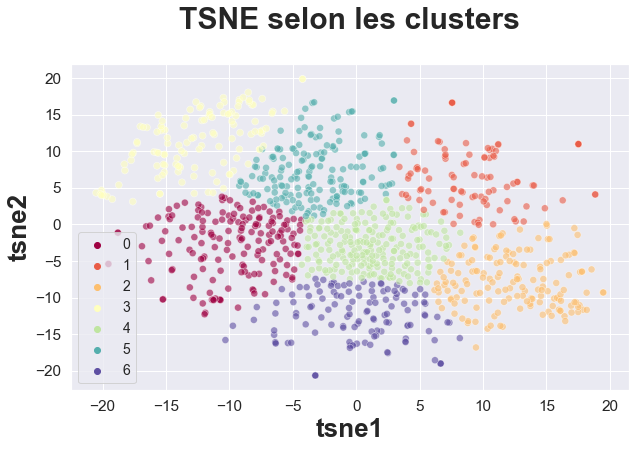

ARI :  0.02309231136037023


In [23]:
plt.figure(figsize=(10,6))
sn.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette="Spectral", s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

print("ARI : ", metrics.adjusted_rand_score(x, cls.labels_))

Noud obtenons un ARI Score d'à peine 0.02... Nous allons réaliser une matrice de confusion même si nous voyons que cette méthode ne porte pas ses fruits.

In [24]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    166
1     99
2    157
3    125
4    209
5    168
6    125
Name: class, dtype: int64

In [26]:
conf_mat = metrics.confusion_matrix(x, cls.labels_)
print(conf_mat)

[[11 18 20 20 49 20 12]
 [25 11 19 19 19 46 11]
 [30 11 17 22 29 22 19]
 [42  6 13  9 42 20 18]
 [20 12 19 19 34  8 38]
 [25 17 37 10 25 26 10]
 [13 24 32 26 11 26 17]]


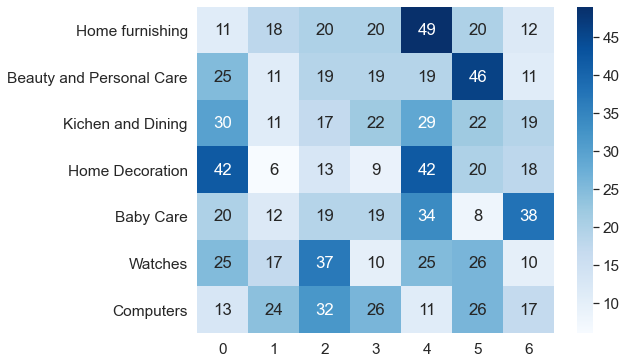

In [27]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in class_names],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (8,6))
sn.heatmap(df_cm, annot=True, cmap="Blues")

Cette méthode est **non concluante**, nous passons à la suite avec une approche Deep Learning grâce aux CNN.

## Approche Deep Learning

### Séparation de nos données en Train/Test
Afin de pouvoir construire un modèle de classification d'images et de pouvoir ensuite l'évaluer nous avons besoin de séparer notre jeu de donnée en deux : Train & Test. 

In [59]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.1)

In [60]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [61]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of test examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 945
Number of test examples: 105
Each image is of size: (150, 150)


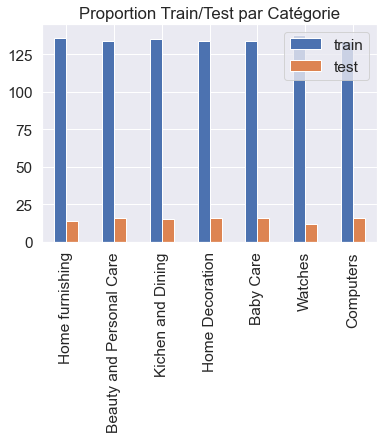

In [62]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.title('Proportion Train/Test par Catégorie')
plt.show()

Nous allons scaler nos données.

### Création d'un CNN avec Keras

Nous allons maintenant construire notre propre réseau convolutif de neurones. Ensuite nous compilerons les différentes couches du modèle afin de pouvoir l'entrainer avec nos données. Finalement nous passerons à son évaluation grâce à notre jeu de test, puis une analyse des erreurs obtenues.

Nous allons construire un modèle simple composé de plusieurs couches telles que :
* Conv2D: (32 filtres de taille 3x3) Extraction des features de l'image.
* MaxPooling2D: Réduction par 2 de la taille de l'image.
* Flatten: Permet de réduire la dimmension d'un 2d-array à 1d-array.
* Relu  : Pour chaque valeur reçue 'x', il retourne 'max(x, 0)'.
* Softmax: 7 neurones en entrée qui va nous permettre de calculer la probabilité de chaque image d'appartenir à une des 7 catégories.

In [63]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(7, activation=tf.nn.softmax)
])

Nous pouvons maintenant compiler notre modèle en ajoutant un optimizer : Adam

In [64]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Nous allons fit le modèle avec nos données d'entrainement. Le réseau de neurones va apprendre par lui même les paterns afin de distinguer chaque catégorie.

In [65]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
6/6 [==============================] - 9s 1s/step - loss: 4.4792 - accuracy: 0.1323 - val_loss: 2.1503 - val_accuracy: 0.1905
Epoch 2/20
6/6 [==============================] - 7s 1s/step - loss: 1.9453 - accuracy: 0.2566 - val_loss: 1.9035 - val_accuracy: 0.2328
Epoch 3/20
6/6 [==============================] - 7s 1s/step - loss: 1.8602 - accuracy: 0.2553 - val_loss: 1.8134 - val_accuracy: 0.2487
Epoch 4/20
6/6 [==============================] - 7s 1s/step - loss: 1.6730 - accuracy: 0.4405 - val_loss: 1.6211 - val_accuracy: 0.3915
Epoch 5/20
6/6 [==============================] - 7s 1s/step - loss: 1.4032 - accuracy: 0.5833 - val_loss: 1.6135 - val_accuracy: 0.4180
Epoch 6/20
6/6 [==============================] - 7s 1s/step - loss: 1.1728 - accuracy: 0.6138 - val_loss: 1.4707 - val_accuracy: 0.4497
Epoch 7/20
6/6 [==============================] - 7s 1s/step - loss: 0.9625 - accuracy: 0.6958 - val_loss: 1.3891 - val_accuracy: 0.4921
Epoch 8/20
6/6 [=========================

In [66]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

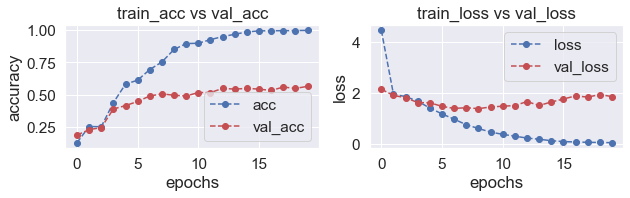

In [67]:
plot_accuracy_loss(history)

Nous évaluons maintenant le modèle sur le jeu de données test.

In [68]:
test_loss = model.evaluate(test_images, test_labels)

4/4 [==============================] - 0s 62ms/step - loss: 1.6927 - accuracy: 0.5714


Nous obtenons ici une accuracy de 57% sur le jeu de test. Nous avons un problème de sous-apprentissage du fait que nous n'avons que peu de données.

Regardons maintenant quelques exemples d'erreurs.

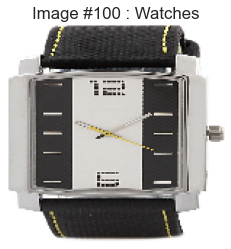

In [69]:
predictions = model.predict(test_images)     
pred_labels = np.argmax(predictions, axis = 1) 

display_random_image(class_names, test_images, pred_labels)

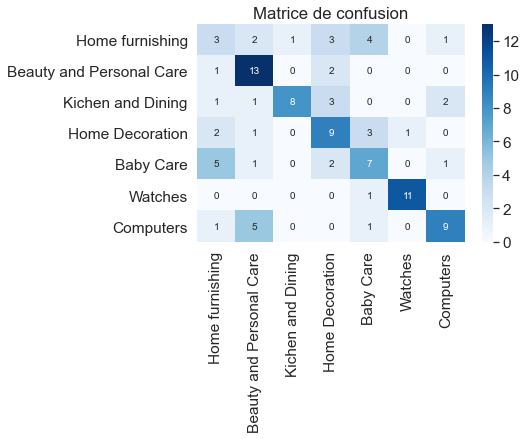

<Figure size 576x432 with 0 Axes>

In [70]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
plt.figure(figsize = (8,6))
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax, cmap="Blues")
ax.set_title('Matrice de confusion')
plt.show()

Conclusion de notre modèle de deep learning : **Il manque d'entrainement et de données !**

Le modèle à du mal à définir les catégories, notamment les catégories "Home furnishing", "Baby Care" & "Home Decoration".


### Transfert learning avec VGG16
Nous avons trop peu d'images afin de bien entrainer un modèle par nous-mêmes. C'est pour cela que nous allons désormais utiliser un modèle déjà entraîné, auquel nous n'auront qu'à ajouter une dernière couche pour qu'il s'adapte à nos catégories.

Pour ce transfert learning nous allons utiliser le modèle de réseau de neurones convolutif VGG16, déjà entrainé sur la banque d'images ImageNet.

#### Extraction des features VGG ImageNet

Nous allons récuperer ce modèle avec le paramètre **include_top=False** permettant d'exclure les dernières couches que nous créerons nous-mêmes par la suite.

In [71]:
model = VGG16(weights='imagenet', include_top=False)

Essayons d'avoir directement nos catégories avec VGG16.

In [72]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

#### Visualisation des catégories (PCA) 

In [73]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [74]:
pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X)

PCA_df = pd.DataFrame(data = C
             , columns = ['C1', 'C2'])

In [75]:
PCA_df['labels']=train_labels

In [76]:
label_names =[]

for i in range(train_labels.shape[0]):
    label_names.append(class_names[PCA_df.labels[i]])

PCA_df['label_names'] = label_names

In [77]:
PCA_df.head()

,C1,C2,labels,label_names
0,-1.517944,-7.957323,1,Beauty and Personal Care
1,-2.745383,0.031015,6,Computers
2,-6.091301,9.046531,1,Beauty and Personal Care
3,1.759006,-5.665989,0,Home furnishing
4,3.354214,-1.768521,3,Home Decoration


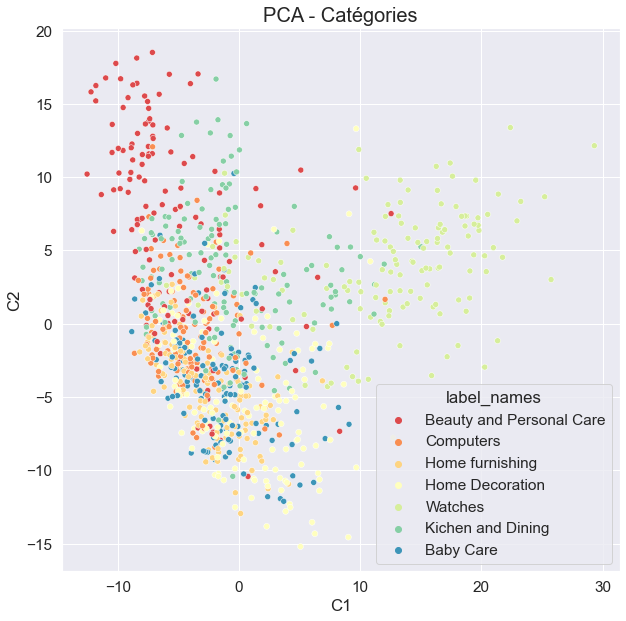

In [78]:
f, ax = plt.subplots(figsize=(10,10))
plt.title('PCA - Catégories', fontsize=20)
sn.scatterplot(data=PCA_df,x="C1", y="C2", hue="label_names", palette="Spectral", legend='auto')

Nous pouvons déjà indentifier des clusters grâce à cette PCA. En effet les images des catégories "Watches" & "Beauty and Personal Care" se regroupent dans des clusters. Cependant les autres restent très mélangées entre elles et il difficile de les distinguer.

Utiliser VGG directement re reste pas assez performant, nous allons devoir entraîner une couche par dessus afin d'améliorer les résultats.

#### Entraînement d'une couche supplémentaire  sur VGG

Entraînons maintenant une simple couche fully-connected.

In [79]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(7, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
6/6 [==============================] - 0s 30ms/step - loss: 1.7548 - accuracy: 0.3532 - val_loss: 1.2464 - val_accuracy: 0.5926
Epoch 2/20
6/6 [==============================] - 0s 12ms/step - loss: 0.9535 - accuracy: 0.7288 - val_loss: 0.9333 - val_accuracy: 0.6931
Epoch 3/20
6/6 [==============================] - 0s 14ms/step - loss: 0.6714 - accuracy: 0.7937 - val_loss: 0.8235 - val_accuracy: 0.7196
Epoch 4/20
6/6 [==============================] - 0s 12ms/step - loss: 0.4981 - accuracy: 0.8466 - val_loss: 0.7583 - val_accuracy: 0.7407
Epoch 5/20
6/6 [==============================] - 0s 12ms/step - loss: 0.3634 - accuracy: 0.8955 - val_loss: 0.7230 - val_accuracy: 0.7619
Epoch 6/20
6/6 [==============================] - 0s 12ms/step - loss: 0.2702 - accuracy: 0.9418 - val_loss: 0.7231 - val_accuracy: 0.7513
Epoch 7/20
6/6 [==============================] - 0s 13ms/step - loss: 0.2057 - accuracy: 0.9643 - val_loss: 0.6927 - val_accuracy: 0.7619
Epoch 8/20
6/6 [===========

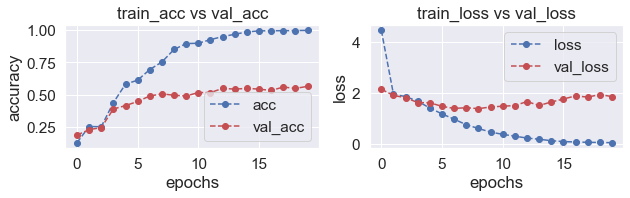

In [80]:
plot_accuracy_loss(history)

In [81]:
test_loss = model2.evaluate(test_features, test_labels)

4/4 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.7905


Nous obtenons ici une accuracy de 79%.

#### Fine-Tuning VGG16

Nous allons ajouter notre dernière couche au modèle VGG16.

In [82]:
model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-3].output)

In [83]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [84]:
train_features.shape

(945, 9, 9, 512)

In [85]:
model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) 
layer_input = Input(shape = (9, 9, 512))

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(7,activation='softmax')(x)

new_model = Model(layer_input, x)

In [86]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [87]:
new_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 9, 9, 512)]       0         
_________________________________________________________________
block5_conv1 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv2 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv3 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 64)          294976    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 64)          0   

In [88]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
6/6 [==============================] - 14s 2s/step - loss: 2.1031 - accuracy: 0.1481 - val_loss: 2.2325 - val_accuracy: 0.1640
Epoch 2/15
6/6 [==============================] - 13s 2s/step - loss: 1.9113 - accuracy: 0.2222 - val_loss: 1.6551 - val_accuracy: 0.2963
Epoch 3/15
6/6 [==============================] - 14s 2s/step - loss: 1.6459 - accuracy: 0.3386 - val_loss: 1.5202 - val_accuracy: 0.4074
Epoch 4/15
6/6 [==============================] - 14s 2s/step - loss: 1.4536 - accuracy: 0.4511 - val_loss: 1.3267 - val_accuracy: 0.4497
Epoch 5/15
6/6 [==============================] - 14s 2s/step - loss: 1.2525 - accuracy: 0.5159 - val_loss: 1.3114 - val_accuracy: 0.4868
Epoch 6/15
6/6 [==============================] - 14s 2s/step - loss: 1.0808 - accuracy: 0.5966 - val_loss: 1.1098 - val_accuracy: 0.6190
Epoch 7/15
6/6 [==============================] - 13s 2s/step - loss: 0.9465 - accuracy: 0.6680 - val_loss: 1.0450 - val_accuracy: 0.6243
Epoch 8/15
6/6 [==================

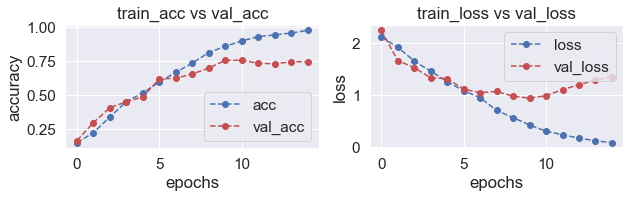

In [89]:
plot_accuracy_loss(history)

In [90]:
predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.7714285714285715


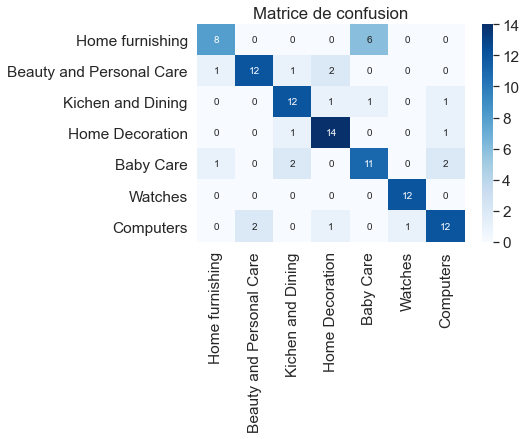

<Figure size 576x432 with 0 Axes>

In [91]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
plt.figure(figsize = (8,6))
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax, cmap="Blues")
ax.set_title('Matrice de confusion')
plt.show()

Nos résultats ont nettement augmentés avec cette approche du Transfert learning. Nous obtenons ici plus de 77% d'accuracy (+20% d'accuracy par rapport à notre premier réseau convolutif).

Nous pouvons désormais dire, qu'en combinant un classifier de texte avec notre réseau de neurones convolutif pour les images, nous sommes en mesure de classifier automatiquement des biens de consommations. 